Copyright (C) 2023 by The RAND Corporation  
See LICENSE and README.md for information on usage and licensing  

# Karzas-Latter-Seiler Model of EMP

This notebook implements the Seiler model, which is a simplified form of the well-known Karzas-Latter treatment of the Electromagnetic Pulse (EMP) phenomena. The original reference is:

    Seiler Jr, Louis W. A calculational model for high altitude EMP. AIR FORCE INST OF TECH WRIGHT-PATTERSON AFB OH SCHOOL OF ENGINEERING, 1975.
    
- The Seiler report is publicly available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/ADA009208.pdf)
- The published KL report is available here: [link](https://journals.aps.org/pr/abstract/10.1103/PhysRev.137.B1369) behind a paywall
- A publicly-available draft version of the KL report is also available through DTIC: [link](https://apps.dtic.mil/sti/pdfs/AD0607788.pdf)

In [1]:
# imports
import os
from tqdm import tqdm
import pickle 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib 
from cycler import cycler

import emp.geometry as geometry
from emp.model import EMPMODEL
from emp.constants import * 
import emp.region_scan as region_scan
import emp.HOB_yield_scan as HOB_yield_scan

# plot settings
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['lines.linewidth'] = 2
plt.rc('font', family='serif',size=16)
matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)
matplotlib.rcParams['axes.prop_cycle'] = cycler(
    color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
    )
matplotlib.rcParams.update(
    {"axes.grid":True,
    "grid.alpha":0.75,
    "grid.linewidth":0.5}
    )
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# PRNG seed
rng = np.random.default_rng(123)

/var/folders/6_/yb1qkrnx3qg54wjfh20svyqh0000gn/T/ipykernel_12366/2678674838.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# create a figures folder
if not os.path.exists('../figures'):
    os.makedirs('../figures')

## The Model

Instantiate the EMP model class and show how it can be used to compute the electric field intensity.

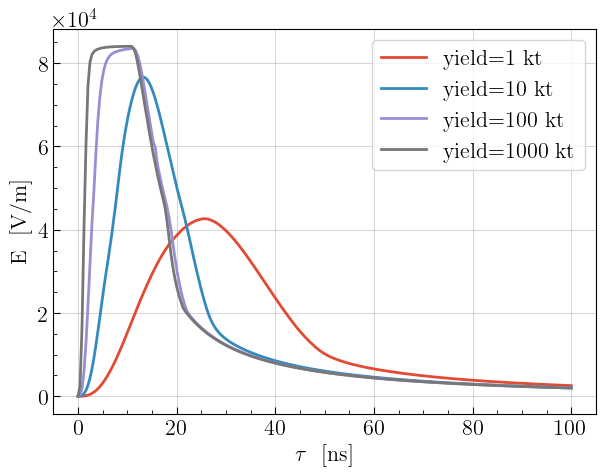

In [3]:
# solve the model for a range of yields
total_yield_kt_list = [1, 10, 100, 1000]
sol_list = []
for total_yield_kt in total_yield_kt_list:
    model = EMPMODEL(total_yield_kt=total_yield_kt)
    sol_list.append(model.solver(np.linspace(0, 100, 250)))

# plot the result
fig, ax = plt.subplots(figsize=(7,5))
for i in range(len(total_yield_kt_list)):
    ax.plot(
        sol_list[i]['tlist'], 
        sol_list[i]['E_norm_at_ground'], 
        label=f'yield={total_yield_kt_list[i]:.0f} kt')
ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel(r'E \ [V/m]')
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.legend()
plt.show()

Inspect some of the many functions that enter into the model - the pulse profile, mean free path, and the Compton rate profile.

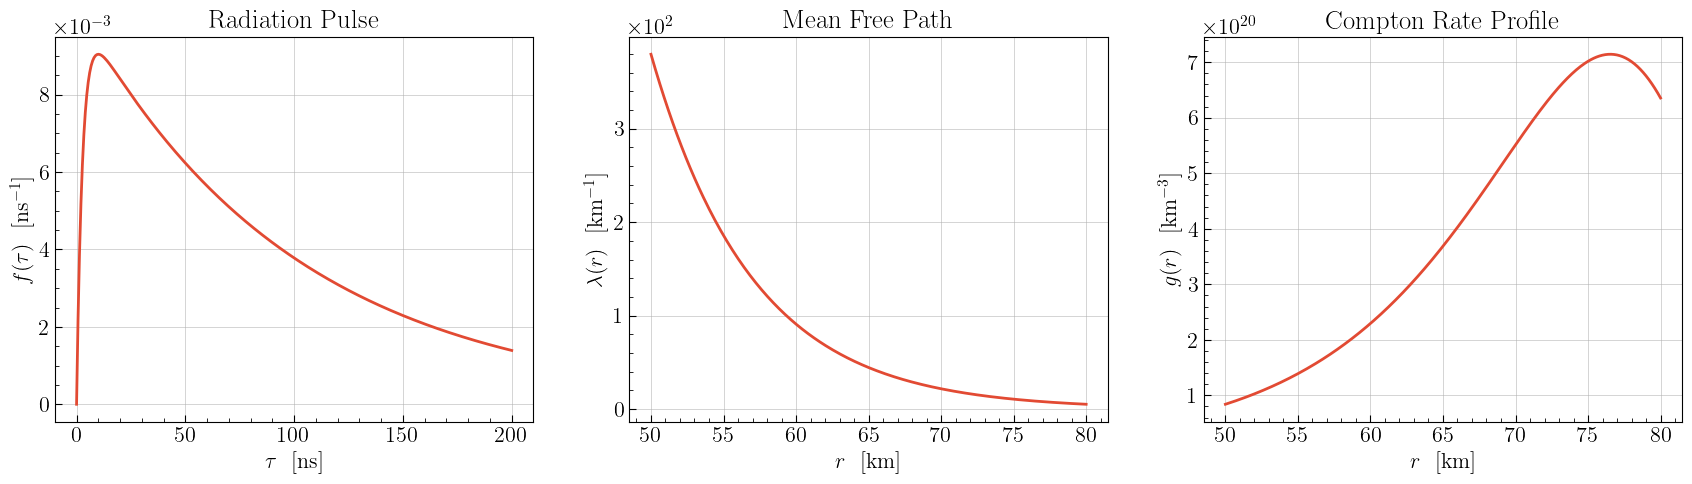

In [4]:
t_list = np.linspace(0, 200, 300)
r_list = np.linspace(model.rmin, model.rmax, 300)

fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title('Radiation Pulse')
ax[0].plot(t_list, model.f_pulse(t_list))
ax[0].set_xlabel(r'$\tau$ \ [ns]')
ax[0].set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')
ax[0].minorticks_on()
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[1].set_title('Mean Free Path')
ax[1].plot(r_list, model.mean_free_path(r_list))
ax[1].set_xlabel(r'$r$ \ [km]')
ax[1].set_ylabel(r'$\lambda(r)$ \ [km$^{-1}$]')
ax[1].minorticks_on()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

ax[2].set_title('Compton Rate Profile')
ax[2].plot(r_list, model.gCompton(r_list))
ax[2].set_xlabel(r'$r$ \ [km]')
ax[2].set_ylabel(r'$g(r)$ \ [km$^{-3}$]')
ax[2].minorticks_on()
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('../figures/MFP_and_ComptonRate.pdf', bbox_inches='tight')
plt.show()

Next, solve the model for a single line-of-sight integration and compare with the digitized results from Seiler.

Ideally, the model output would agree with the HAEMP data. The two curves are qualitatively similar, but show noticeable differences. There are a few implementation details that were not clear from the Seiler report; perhaps these could be the source of the discrepancy. These include the Compton lifetime $T$, stopping distance $R$, and the electron collision frequency.

In [5]:
HOB = 100
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')
Target_Point = geometry.Point(EARTH_RADIUS + HOB, 0.9*phi_B_g, 1.1*lambd_B_g, coordsys='lat/long geo')

/Users/gavinhartnett/Library/CloudStorage/Dropbox/Research/EMP Project/Code/karzas-latter-seiler/emp/model.py:810: UserWarning: Warning, evolution terminated before max EMP intensity has been reached.
  warnings.warn(


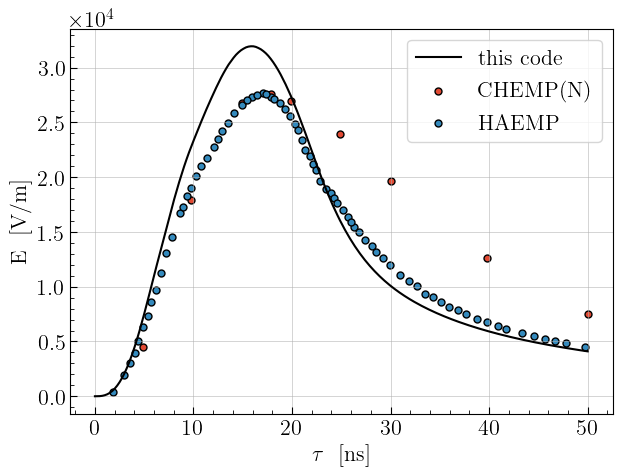

In [6]:
# agreement can be improved by changing r value for E(r) input to nu calculator
model = EMPMODEL(Bnorm=3e-5, Compton_KE=0.75)
sol = model.solver(np.linspace(0, 50, 200))

# load the digitized data from Seiler
df_CHEMP = pd.read_csv("../Seiler Digitized Data/Fig5_CHEMP(N).csv", header=None, names=['t', 'E'])
df_HAEMP = pd.read_csv("../Seiler Digitized Data/Fig5_HAEMP.csv", header=None, names=['t', 'E'])

# plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax.plot(sol['tlist'], sol['E_norm_at_ground'], '-', color='k', label='this code', linewidth=1.5, markersize=2)
ax.scatter(df_CHEMP['t'], df_CHEMP['E'], label='CHEMP(N)', s=25, edgecolor='k')
ax.scatter(df_HAEMP['t'], df_HAEMP['E'], label='HAEMP', s=25, edgecolor='k')
ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel(r'E \ [V/m]')
ax.legend()
ax.minorticks_on()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('../figures/seiler_comparison.pdf', bbox_inches='tight')
plt.show()

Compare the time-dependence of the $\gamma$-rays and the EMP.

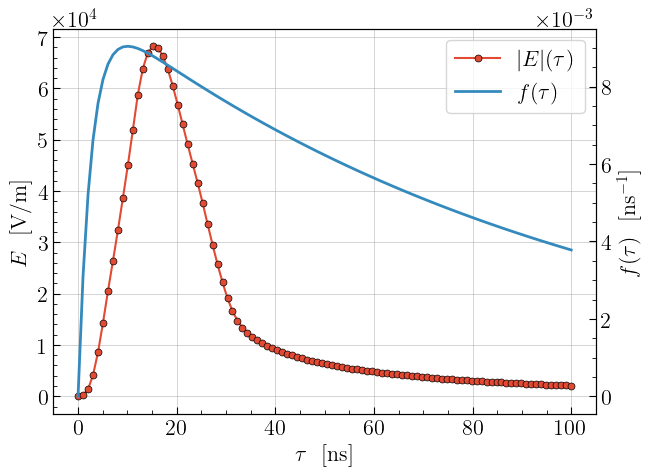

In [7]:
model = EMPMODEL() # instantiate a new model with default parameter values
sol = model.solver(np.linspace(0, 100, 100)) # solve it

# plot
fig, ax = plt.subplots(1, figsize=(7,5))
ax2 = ax.twinx()
ax2.grid(False)

lns0 = ax.plot(
    sol['tlist'], 
    sol['E_norm_at_ground'], 
    '-o',
    label=r'$|E|(\tau)$', 
    color=colors[0],
    linewidth=1.5,
    markersize=5,
    markerfacecolor=colors[0],
    markeredgecolor='k',
    markeredgewidth=0.5
    )

lns1 = ax2.plot(sol['tlist'], model.f_pulse(sol['tlist']), label=r'$f(\tau)$', color=colors[1], linestyle='-')

lns = lns0 + lns1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_xlabel(r'$\tau$ \ [ns]')
ax.set_ylabel(r'$E$ \ [V/m]')#, color=colors[0])
ax2.set_ylabel(r'$f(\tau)$ \ [ns$^{-1}$]')#, color=colors[1])

ax.minorticks_on()
ax2.minorticks_on()

ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('../figures/EMP_and_gamma_pulse.pdf', bbox_inches='tight')
plt.show()

Investigate the effect of changing latitude (this cell takes ~15 minutes to run).

In [8]:
b_field_type = 'dipole'

# burst coordinates 
HOB = 100
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')
t_list = np.linspace(0, 100, 200)

# target latitudes
N_pts_phi = 200 #number of latitude grid points
Delta_angle = geometry.compute_max_delta_angle_1d(Burst_Point)
phi_T_g_list = phi_B_g + np.linspace(-Delta_angle/2, Delta_angle/2, N_pts_phi)

# scan over target locations
data_dic = {'phi_T_g':[], 
            'phi_T_m':[], 
            'A':[], 
            'theta':[], 
            'Bnorm':[],
            'sol':[]
            }

# scan over latitude values
for i in tqdm(range(len(phi_T_g_list))):

    # update target coords
    phi_T_g = phi_T_g_list[i]
    lambd_T_g = lambd_B_g
    Target_Point = geometry.Point(EARTH_RADIUS, phi_T_g, lambd_T_g, coordsys='lat/long geo')

    # get B-field evaluation point
    Midway_Point = geometry.get_line_of_sight_midway_point(Burst_Point, Target_Point)    
    
    # build and solve the model
    model = EMPMODEL(
        HOB=HOB,
        A = geometry.get_A(Burst_Point, Midway_Point),
        theta = geometry.get_theta(Burst_Point, Midway_Point, b_field_type=b_field_type),
        Bnorm = geometry.get_geomagnetic_field_norm(Midway_Point, b_field_type=b_field_type)
    )
    sol = model.solver(t_list)

    # store results
    data_dic['phi_T_g'].append(phi_T_g)
    data_dic['A'].append(geometry.get_A(Burst_Point, Midway_Point))
    data_dic['theta'].append(model.theta)
    data_dic['Bnorm'].append(model.Bnorm)
    data_dic['sol'].append(sol)

100%|██████████| 200/200 [14:34<00:00,  4.37s/it]


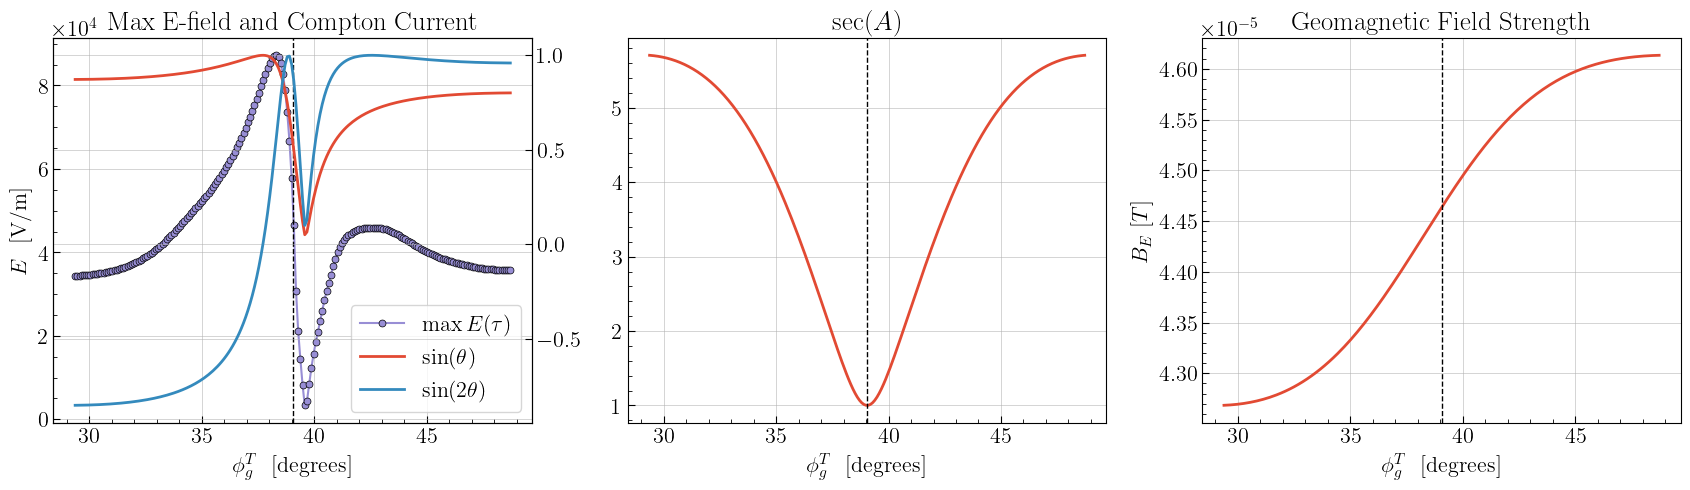

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title('Max E-field and Compton Current')
ax2 = ax[0].twinx()
max_E = np.asarray([np.max(data_dic['sol'][i]['E_norm_at_ground']) for i in range(len(data_dic['sol']))])
lns_E = ax[0].plot(
    180/np.pi * np.asarray(data_dic['phi_T_g']), 
    max_E, 
    '-o', 
    label=r'$\max E(\tau)$', 
    color=colors[2],
    linewidth=1.5,
    markersize=5,
    markerfacecolor=colors[2],
    markeredgecolor='k',
    markeredgewidth=0.5
)            
lns_sin = ax2.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.sin(np.asarray(data_dic['theta'])), 
               '-', label=r'$\sin(\theta)$')
lns_sin2 = ax2.plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.sin(2*np.asarray(data_dic['theta'])), 
               '-', label=r'$\sin(2\theta)$')
lns = lns_E + lns_sin + lns_sin2
labs = [l.get_label() for l in lns]
ax[0].set_ylabel(r'$E$ \ [V/m]')
ax[0].legend(lns, labs, loc='lower right')
ax[0].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[0].minorticks_on()
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[0].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

ax[1].set_title(r'sec$(A)$')
ax[1].plot(180/np.pi * np.asarray(data_dic['phi_T_g']), 1/np.cos(np.asarray(data_dic['A'])))
ax[1].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[1].minorticks_on()
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

ax[2].set_title('Geomagnetic Field Strength')
ax[2].plot(180/np.pi * np.asarray(data_dic['phi_T_g']), np.asarray(data_dic['Bnorm']))
ax[2].set_xlabel(r'$\phi_g^T$ \ [degrees]')
ax[2].set_ylabel(r' $B_E \ [T]$')
ax[2].minorticks_on()
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[2].axvline(x=180/np.pi * phi_B_g, color='k', linestyle='--', linewidth=1)

plt.savefig('../figures/angle_variation_with_latitude.pdf', bbox_inches='tight')
plt.show()

Lastly, plot the source terms for both the Seiler and KL methods (this also takes a few minutes).

In [10]:
# instantiate an EMP model object
model = EMPMODEL(theta=np.pi/4)

# scan over a range of times and calculate each current and conductivity (both Seiler and KL methods)
t_list = np.exp(np.linspace(np.log(1), np.log(1000), 400))

conductivity_list = [model.conductivity((model.rmin + model.rmax)/2, t, 4e3) for t in t_list]
conductivity_KL_list = [model.conductivity_KL((model.rmin + model.rmax)/2, t, 4e3) for t in t_list]

J_theta_list = [model.JCompton_theta((model.rmin + model.rmax)/2, t) for t in t_list]
J_phi_list = [model.JCompton_phi((model.rmin + model.rmax)/2, t) for t in t_list]

J_theta_KL_list = [model.JCompton_theta_KL((model.rmin + model.rmax)/2, t) for t in t_list]
J_phi_KL_list = [model.JCompton_phi_KL((model.rmin + model.rmax)/2, t) for t in t_list]

/Users/gavinhartnett/Library/CloudStorage/Dropbox/Research/EMP Project/Code/karzas-latter-seiler/emp/model.py:652: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  outer_integral = quad(lambda tau: inner_integral(tau), 0.0, t)[0]


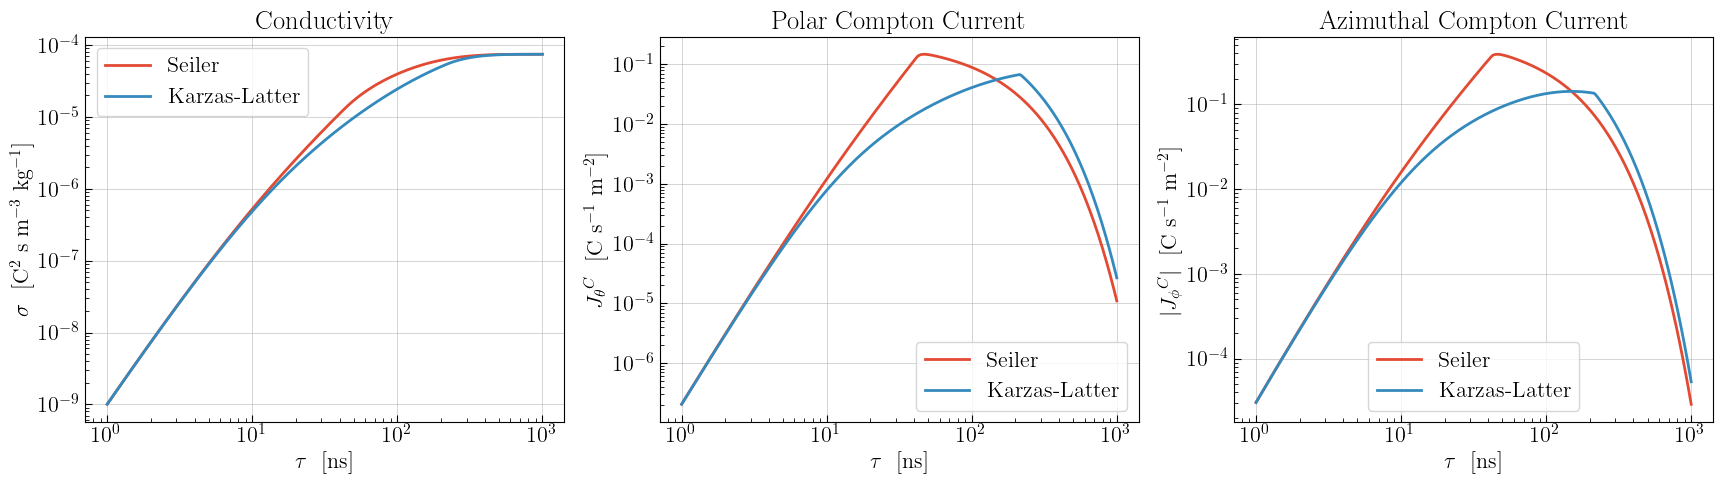

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(3*7,5))

ax[0].set_title(r'Conductivity')
ax[0].plot(t_list, conductivity_list, label='Seiler')
ax[0].plot(t_list, conductivity_KL_list, label='Karzas-Latter')
ax[0].set_xlabel(r'$\tau$ \ [ns]')
ax[0].set_ylabel(r'$\sigma$ \ [C$^2$ s m$^{-3}$ kg$^{-1}$]')
ax[0].minorticks_on()
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[1].set_title(r'Polar Compton Current')
ax[1].plot(t_list, J_theta_list, label='Seiler')
ax[1].plot(t_list, J_theta_KL_list, label='Karzas-Latter')
ax[1].set_xlabel(r'$\tau$ \ [ns]')
ax[1].set_ylabel(r'$J_{\theta}{}^C$ \ [C s$^{-1}$ m$^{-2}$]')
ax[1].minorticks_on()
ax[1].legend()
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[2].set_title(r'Azimuthal Compton Current')
ax[2].plot(t_list, np.abs(J_phi_list), label='Seiler')
ax[2].plot(t_list, np.abs(J_phi_KL_list), label='Karzas-Latter')
ax[2].set_xlabel(r'$\tau$ \ [ns]')
ax[2].set_ylabel(r'$|J_{\phi}{}^C|$ \ [C s$^{-1}$ m$^{-2}$]')
ax[2].minorticks_on()
ax[2].legend()
ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.savefig('../figures/Seiler_vs_KL.pdf', bbox_inches='tight')

plt.show()

## Smile Diagrams

The code can be used to produce the characteristic smile diagrams showing the variation of the EMP intensity as a function of latitude and longitude. This can accomplished by running `python scripts/run_region_scan.py`. Because this takes awhile, here the result from a previous run will be loaded and plotted.

In [12]:
gz_name = 'topeka'
phi_B_g = 39.05 * np.pi/180 #latitude (radians)
lambd_B_g = -95.675 * np.pi/180 #longitude (radians)
HOB = 100
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')

topeka_data = np.load("../data/region_scan_topeka.pkl", allow_pickle=True)
x, y, z = region_scan.data_dic_to_xyz(topeka_data)

contourf, levels = region_scan.contour_plot(x, y, z, Burst_Point, show=False)

region_scan.folium_plot(
    contourf, 
    Burst_Point.phi_g * 180/np.pi,
    Burst_Point.lambd_g * 180/np.pi,
    levels,
    save_path="../figures/topeka_smile.png"
    )

Next, consider a burst point in the Southern hemisphere, for example Sydney, Australia.

In [13]:
# burst coordinates
phi_B_g = -33.86 * np.pi/180 #latitude (radians)
lambd_B_g = 151.2093 * np.pi/180 #longitude (radians)
HOB = 100
Burst_Point = geometry.Point(EARTH_RADIUS + HOB, phi_B_g, lambd_B_g, coordsys='lat/long geo')

sydney_data = np.load("../data/region_scan_sydney.pkl", allow_pickle=True)
x, y, z = region_scan.data_dic_to_xyz(sydney_data)

contourf, levels = region_scan.contour_plot(x, y, z, Burst_Point, show=False)

region_scan.folium_plot(
    contourf, 
    Burst_Point.phi_g * 180/np.pi,
    Burst_Point.lambd_g * 180/np.pi,
    levels,
    save_path="../figures/sydney_smile.png"
    )

## Variation of $\sin\theta$ with latitude

The general shape of the smile diagram can be understood by considering how $\sin\theta$ varies over the surface of the Earth, where $\theta$ is the angle between the local orientation of the geomagnetic field and the line of sight vector.

In [14]:
# set-up
phi_B_m_list = [15*i * np.pi/180 for i in range(1, 6)] # burst latitude grid
N_pts_HOB = 30 # number of heights to consider
HOB_list = np.linspace(55, 400, N_pts_HOB) # HOB grid

phi_min_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
phi_max_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
ground_dists_min_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))
ground_dists_max_theta = np.zeros((len(phi_B_m_list), len(HOB_list)))

for i in range(len(phi_B_m_list)):
    for j in range(len(HOB_list)):

        Burst_Point = geometry.Point(EARTH_RADIUS + HOB_list[j], phi_B_m_list[i], 0, 'lat/long mag')
        
        def get_sin_theta_lat(phi_T_m): 
            Target_Point = geometry.Point(EARTH_RADIUS, phi_T_m, 0, 'lat/long mag')
            Midway_Point = geometry.get_line_of_sight_midway_point(Burst_Point, Target_Point)
            return np.sin(geometry.get_theta(Burst_Point, Midway_Point, b_field_type='dipole'))

        Delta_angle = geometry.compute_max_delta_angle_1d(geometry.Point(EARTH_RADIUS + HOB_list[j], phi_B_m_list[i], 0, 'lat/long mag'))

        # minimization
        result = scipy.optimize.minimize_scalar(get_sin_theta_lat, method='bounded', bounds=(phi_B_m_list[i] - Delta_angle/2, phi_B_m_list[i] + Delta_angle/2))        
        Target_Point = geometry.Point(EARTH_RADIUS, result.x, 0, 'lat/long mag')    
        phi_min_theta[i,j] = np.arcsin(result.fun)
        ground_dists_min_theta[i,j] = geometry.great_circle_distance(Burst_Point, Target_Point)

        # maximization
        result = scipy.optimize.minimize_scalar(lambda x: -get_sin_theta_lat(x), method='bounded', bounds=(phi_B_m_list[i] - Delta_angle/2, phi_B_m_list[i] + Delta_angle/2))        
        Target_Point = geometry.Point(EARTH_RADIUS, result.x, 0, 'lat/long mag')
        phi_max_theta[i,j] = np.arcsin(result.fun)
        ground_dists_max_theta[i,j] = geometry.great_circle_distance(Burst_Point, Target_Point)

Reproduce Fig 2-11 of  *E. Savage, J. Gilbert, and W. Radasky, The early-time (e1) high-altitude electromagnetic pulse (hemp) and its impact on the us power grid, Report Meta (2010)*:

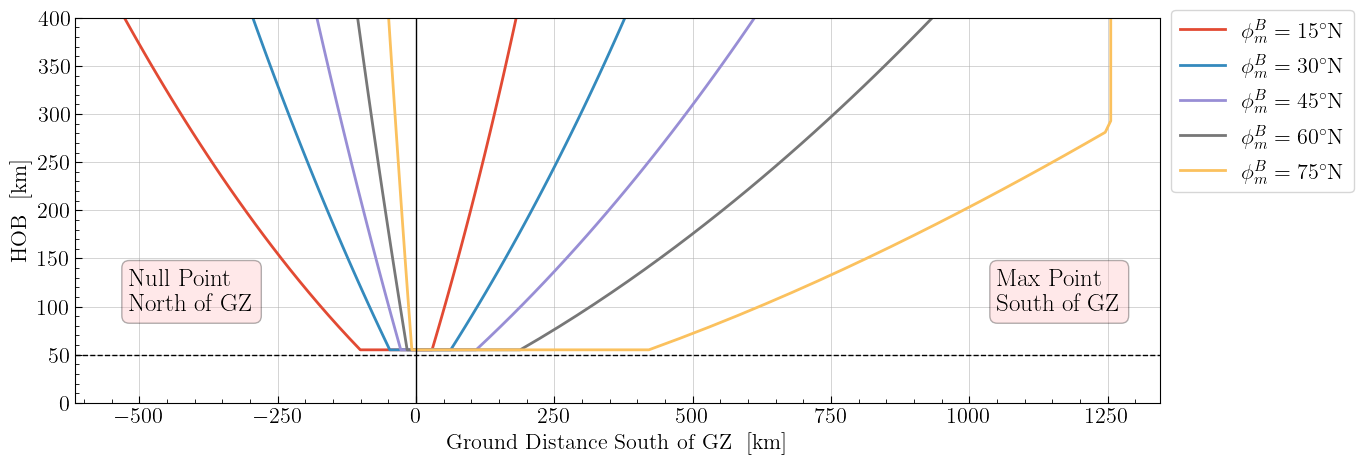

In [15]:
# plot
fig, ax = plt.subplots(figsize=(2*7,5))

for i in range(len(phi_B_m_list)):
    
    ax.plot(
        list(-ground_dists_min_theta[i, ::-1]) + list(ground_dists_max_theta[i,:]), 
        list(HOB_list)[::-1] + list(HOB_list), 
        '-', 
        label=r'$\phi_m^B = %.0f^{\circ}$N' % (180/np.pi * phi_B_m_list[i])
        )

ax.axhline(ABSORPTION_LAYER_UPPER, linestyle='--', linewidth=1, color='k')    
ax.axvline(0, linestyle='-', linewidth=1, color='k')    
ax.legend(bbox_to_anchor=(1., 1.05))
ax.set_xlabel(r'Ground Distance South of GZ \ [km]')
ax.set_ylabel(r'HOB \ [km]')
#ax.set_title(r'Ground Distance to $\sin\theta$ Extremal Points')
ax.set_ylim([0, max(HOB_list)])
ax.minorticks_on()

props = dict(boxstyle='round', facecolor=colors[-1], alpha=0.3, edgecolor='black')
ax.text(0.85, 0.35, 'Max Point\nSouth of GZ', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)
ax.text(0.05, 0.35, 'Null Point\nNorth of GZ', transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

plt.savefig('../figures/fig_2_11_savage_et_al.pdf', bbox_inches='tight')
plt.show()

## Variation of intensity with HOB and weapon yield

Lastly, explore the variation of HOB and total weapon yield on the maximum EMP intensity as measured at ground zero.

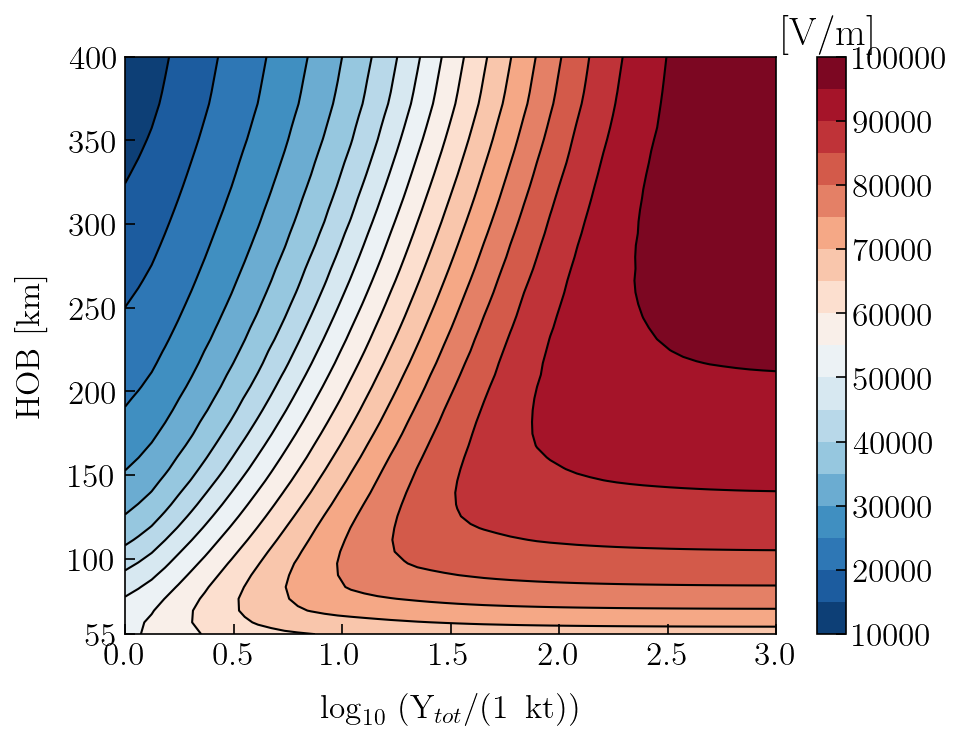

In [16]:
HOB_yield_data = np.load("../data/HOB_yield_scan.pkl", allow_pickle=True)
x, y, z = HOB_yield_scan.data_dic_to_xyz(HOB_yield_data)
contourf = HOB_yield_scan.contour_plot(x, y, z)